# Simulating GMB paths
See Binomial Trees notebook for definition of GBM and
$$
S_{t}=S_{0} \operatorname{e x p} \biggl( \left( \mu-{\frac{\sigma^{2}} {2}} \right) t+\sigma W_{t} \biggr). 
$$
$W_{t}$ at different time points can be simulated by definition by adding independent Gaussians.

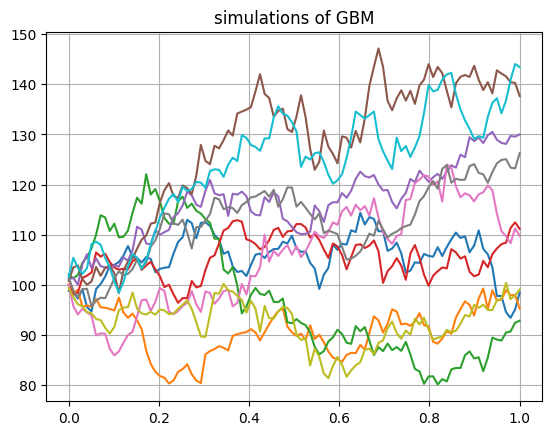

In [62]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_gbm(S0, mu, sigma, T, dt, num_paths):
    """Simulate multiple paths of the geometric Brownian motion process S_{t}=S_{0} exp((r-sigma^2/2)t + sigma*W_{t})"""
    N = round(T/dt)
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = (num_paths, N)) 
    W = np.cumsum(W, axis=1)*np.sqrt(dt) ### standard brownian motion
    X = (mu - 0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) ### geometric brownian motion
    return S

# Example usage
np.random.seed(40)
S0,r,sigma,T,dt,num_paths = 100,0.05,0.2,1,0.01,10
paths = simulate_gbm(S0, r, sigma, T, dt, num_paths)

# Plot the simulated geometric Brownian motion paths
for i in range(num_paths):
    plt.plot(np.linspace(0,T,round(T/dt)),paths[i, :])
    plt.grid(True)
    plt.title("simulations of GBM")
plt.show()

# Regression
Here some code testing regression in Python.

[[2.24277932 0.5787074 ]]
[7.87412086]


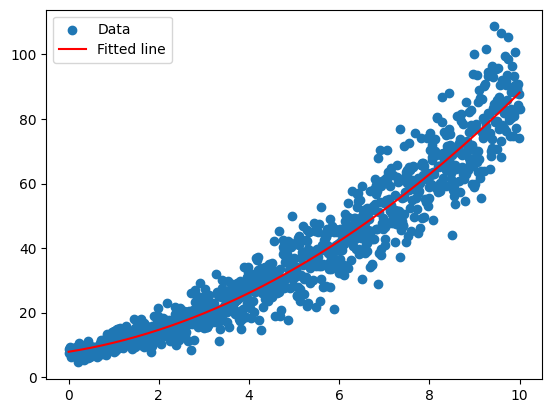

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Generate some example data
np.random.seed(0)
x = np.linspace(0, 10, 1000).reshape(-1, 1)
y = 0.5*x**2+ 3 * x + 2 + np.random.normal(0, 1+1*x, size=x.shape)+5

# Create a linear regression model
model = LinearRegression()
X = np.column_stack((x,x**2))
# Fit the model to the data
model.fit(X, y)

print(model.coef_)
print(model.intercept_)

# Plot the data and the fitted line
plt.scatter(x, y, label='Data')
plt.plot(x, model.predict(X), 'r', label='Fitted line')
plt.legend()
plt.show()

# Least-Square Monte Carlo

In [116]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


def least_square_Monte_Carlo(paths,r,dt,T,payoff,K):
    N = round(T/dt)
    value = payoff(paths[:,-1])

    for i in range(N): # stepping backwards in time 
       value = value*np.exp(-r*dt) # discounting 
       mask = paths[:,-i-1] < K
       ITMpaths = paths[mask]
       ITMvalue = value[mask]
       model = LinearRegression()
       X = np.column_stack((ITMpaths[:,-i-1],ITMpaths[:,-i-1]**2))
       model.fit(X,ITMvalue)
       interpolated = model.predict(X)
       exercise = payoff(ITMpaths[:,-i-1])

    #    if i in {5,20,40,60,80,100}:
    #         plt.scatter(ITMpaths[:,-i-1],interpolated,label = "interpolated",s=5)
    #         plt.scatter(ITMpaths[:,-i-1],exercise,label = "exercise",s=5)
    #         plt.scatter(ITMpaths[:,-i-1],ITMvalue,label = "continuation",s = 5, alpha = 0.5)
    #         plt.legend()
    #         plt.show()
       value[mask] = np.maximum(interpolated,exercise)

    return np.mean(value)
    
def payoff_put(S,K): return np.maximum(K-S,0)

# np.random.seed(40)

S0,mu,sigma,T,dt,num_paths = 100,0.07,0.3,1,0.01,10000
r = 0.05
K = 110

paths = simulate_gbm(S0, mu, sigma, T, dt, num_paths)
val = least_square_Monte_Carlo(paths,r,dt,T,lambda S: payoff_put(S,K),K)
print(val)

15.16977161910168


In [96]:
10 in {10,20,30}

True